In [3]:
from __future__ import division
import utils
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.externals import joblib

from catboost import CatBoostClassifier, Pool, cv
from sklearn.pipeline import Pipeline 
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, f1_score, confusion_matrix, precision_score, recall_score

from matplotlib import pyplot as plt
%matplotlib inline

pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
# np.set_printoptions(threshold=np.nan)  

In [5]:
# load the model from disk
model=joblib.load('/home/gjain/lightgbm.pkl')

# Read dataset

In [40]:
df=pd.read_csv('/home/gjain/test_data.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

/home/ubuntu/yes/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.target.value_counts()

0    267449
1    239   
Name: target, dtype: int64

In [33]:
categorical_features_pos= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24,
 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 65, 58, 67, 57, 68, 69, 71]

all_cols=['affiliate','channelcode',
       'local_trans_amt', 'trans_currency', 'nonmor', 'payment_method', 'eci',
       'card_cvvmatch', 'card_avsmatch', 'customer_title', 'website_language',
       'brand_continent', 'HasTicketInsurance', 'HasInsurance', 'HasBaggage',
       'HasBaggage_Sale', 'HasAirhelpPlus', 'UsedVoucher', 'HasSP', 'gender',
       'BookerCity', 'BookerCountry_Name', 'TotalAmountEUR', 'airline',
       'Consolidator', 'OriginAirportCode', 'OriginCityName',
       'OriginCountryName', 'OriginWorldPartName', 'OriginRegion',
       'OriginSubRegion', 'DestinationAirportCode', 'DestinationCityName',
       'DestinationCountryName', 'DestinationWorldPartName',
       'DestinationRegion', 'DestinationSubRegion', 'Supplier',
       'DomesticOrInternational', 'Haul', 'OneWayOrReturn', 'IsCombinedOneWay',
       'IsITFare', 'TotalNumberOfPassengers', 'TotalNumberOfAdults',
       'TotalNumberOfChildren', 'TotalNumberOfInfants', 'COW_NumberOfSegments',
       'COW_NumberOfInboundSegments', 'COW_NumberOfOutboundSegments',
       'NumberOfTickets', 'FareBaseAmount', 'HasSplitPnr', 'DeviceType',
#        'OrderDateBrandTime_Month',
        'IsLowCost', 'email_user_id_len',
       'email_domain', 'dob_month', 'bookerIsTravelAgency',
       'successful_attempt_no', 'country_ip_flight_MatchScore',
       'flight_distance', 'days_to_departure', 'vacation_length',
       'cities_in_itinerary', 'cabin_class', 'name_len', 'weekend_booking',
       'booking_daytime', 'bookerAgeBracket', 'email_sanity_score',
          #new ad
         'OrderDateBrandTime_DayOfWeek',
         'ordermonth_sin','ordermonth_cos','departuremonth_sin','departuremonth_cos']

In [36]:
all_cat_cols=['affiliate','channelcode','trans_currency','nonmor','payment_method','eci','card_cvvmatch','card_avsmatch',
              'customer_title','website_language','brand_continent','HasTicketInsurance','HasInsurance','HasBaggage',
              'HasBaggage_Sale','HasAirhelpPlus','UsedVoucher','HasSP','gender','BookerCity','BookerCountry_Name','airline',
              'Consolidator','OriginAirportCode','OriginCityName','OriginCountryName','OriginWorldPartName','OriginRegion',
          'OriginSubRegion','DestinationAirportCode','DestinationCityName','DestinationCountryName','DestinationWorldPartName',
              'DestinationRegion','DestinationSubRegion','Supplier','DomesticOrInternational','Haul','OneWayOrReturn',
              'IsCombinedOneWay','IsITFare','HasSplitPnr','DeviceType','IsLowCost','email_domain','cabin_class',
              'bookerIsTravelAgency','weekend_booking','dob_month','booking_daytime', 'bookerAgeBracket',
          'OrderDateBrandTime_DayOfWeek']


df['dob_month'].replace('None', 0, inplace=True)

try_dict=joblib.load('/home/gjain/try_dict.pkl')


for col in all_cat_cols:
    df[col]=df[col].map(try_dict[col])
    df[col]=df[col].astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [29]:
df=df[df.channelcode !=np.nan]

In [37]:
df[all_cols].head()

,affiliate,channelcode,local_trans_amt,trans_currency,nonmor,payment_method,eci,card_cvvmatch,card_avsmatch,customer_title,website_language,brand_continent,HasTicketInsurance,HasInsurance,HasBaggage,HasBaggage_Sale,HasAirhelpPlus,UsedVoucher,HasSP,gender,BookerCity,BookerCountry_Name,TotalAmountEUR,airline,Consolidator,OriginAirportCode,OriginCityName,OriginCountryName,OriginWorldPartName,OriginRegion,OriginSubRegion,DestinationAirportCode,DestinationCityName,DestinationCountryName,DestinationWorldPartName,DestinationRegion,DestinationSubRegion,Supplier,DomesticOrInternational,Haul,OneWayOrReturn,IsCombinedOneWay,IsITFare,TotalNumberOfPassengers,TotalNumberOfAdults,TotalNumberOfChildren,TotalNumberOfInfants,COW_NumberOfSegments,COW_NumberOfInboundSegments,COW_NumberOfOutboundSegments,NumberOfTickets,FareBaseAmount,HasSplitPnr,DeviceType,IsLowCost,email_user_id_len,email_domain,dob_month,bookerIsTravelAgency,successful_attempt_no,country_ip_flight_MatchScore,flight_distance,days_to_departure,vacation_length,cities_in_itinerary,cabin_class,name_len,weekend_booking,booking_daytime,bookerAgeBracket,email_sanity_score,OrderDateBrandTime_DayOfWeek,ordermonth_sin,ordermonth_cos,departuremonth_sin,departuremonth_cos
0,37,396.00,2095.49,1,0,26,5.00,P,U,Mr.,ES,Americas,True,False,False,False,False,False,False,M,BUENOS AIRES,Argentina,48.62,LATAM AIRLINES,AVICO,ADZ,San Andrés,Colombia,South America,Americas,South America,BOG,Bogota,Colombia,South America,Americas,South America,Amadeus,Domestic,Short Haul,One Way,False,False,1,1,0,0,1,0,1,1,2043.40,False,Mobile,False,14,gmail.com,6,False,1,0,-9999,53,0,2,Economy,32,0,2,2,0.88,2,-0.00,1.00,0.87,0.50
1,37,169.00,3343.50,1,0,26,5.00,P,U,Ms.,ES,Americas,False,False,False,False,False,False,False,F,VILLA CONSTITUCION,Argentina,76.49,LATAM AIRLINES,AVICO,ADZ,San Andrés,Colombia,South America,Americas,South America,CTG,Cartagena,Colombia,South America,Americas,South America,Amadeus,Domestic,Short Haul,One Way,False,False,3,3,0,0,1,0,1,3,3343.50,False,Desktop,False,7,outlook.es,4,False,2,0,-9999,125,0,2,Economy,17,0,1,2,0.00,6,-0.00,1.00,0.50,-0.87
2,37,1.00,4634.60,1,0,26,5.00,P,U,Mr.,ES,Americas,False,False,False,False,False,True,True,M,SAN MIGUEL DE TUCUMAN,Argentina,106.94,LATAM AIRLINES,AVICO,ADZ,San Andrés,Colombia,South America,Americas,South America,CTG,Cartagena,Colombia,South America,Americas,South America,Amadeus,Domestic,Short Haul,One Way,False,False,4,4,0,0,1,0,1,4,4435.60,False,Desktop,False,10,hotmail.com,11,False,1,0,-9999,22,0,2,Economy,25,0,2,2,0.70,5,-0.00,1.00,0.50,0.87
3,37,348.00,2664.16,1,0,16,3.00,M,U,Mr.,ES,Americas,False,False,False,False,False,False,False,M,NEW YORK,EE.UU.,61.47,NORWEGIAN AIR,CONAR,AEP,Buenos Aires,Argentina,South America,Americas,South America,COR,Cordoba,Argentina,South America,Americas,South America,Amadeus,Domestic,Short Haul,One Way,False,False,2,2,0,0,1,0,1,2,2664.16,False,Desktop,False,8,gmail.com,2,False,1,0,-9999,48,0,2,Economy,12,0,2,2,0.68,5,-0.00,1.00,0.87,0.50
4,37,348.00,2020.08,1,0,28,3.00,M,U,Ms.,ES,Americas,False,False,False,False,False,False,False,F,MOSCOW,Rusia,46.73,NORWEGIAN AIR,CONAR,AEP,Buenos Aires,Argentina,South America,Americas,South America,COR,Cordoba,Argentina,South America,Americas,South America,Amadeus,Domestic,Short Haul,One Way,False,False,1,1,0,0,1,0,1,1,2020.08,False,Desktop,False,8,gmail.com,7,False,2,0,-9999,52,0,2,Economy,15,0,3,2,0.52,4,-0.00,1.00,0.87,0.50


In [38]:
df.isnull().sum()

timestamp                       0    
order_number                    0    
pay_id                          0    
affiliate                       0    
channelcode                     163  
local_trans_amt                 0    
trans_currency                  0    
nonmor                          0    
payment_method                  0    
eci                             16419
card_cvvmatch                   0    
card_avsmatch                   0    
customer_title                  0    
website_language                0    
brand_continent                 0    
HasTicketInsurance              0    
HasInsurance                    0    
HasBaggage                      0    
HasBaggage_Sale                 0    
HasAirhelpPlus                  0    
UsedVoucher                     0    
HasSP                           0    
gender                          0    
BookerCity                      0    
BookerCountry_Name              0    
TotalAmountEUR                  0    
airline     

# Predict

In [9]:
X_train=df[all_cols].as_matrix()
predictions=pd.DataFrame(model.predict_proba(X_train))
y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=0.7 else 0 )

print(f1_score(y_true=df.target, y_pred=y_pred, average=None))
print(precision_score(y_true=df.target, y_pred=y_pred, average=None))
print(recall_score(y_true=df.target, y_pred=y_pred, average=None))

ValueError: could not convert string to float: 'VAYAMAAR'

In [27]:
df['dob_month'].replace('None', 0, inplace=True)

train_data = Pool(
    data=df[all_cols],
    cat_features=categorical_features_pos,
    has_header=True,
    thread_count=-1
)

probs=model.predict_proba(train_data)
predictions=pd.DataFrame(probs)

In [28]:
y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=0.97 else 0 )
print(f1_score(y_true=df.target, y_pred=y_pred, average=None))
print(precision_score(y_true=df.target, y_pred=y_pred, average=None))
print(recall_score(y_true=df.target, y_pred=y_pred, average=None))

[0.99944481 0.29787234]
[0.99934207 0.3423913 ]
[0.99954758 0.26359833]


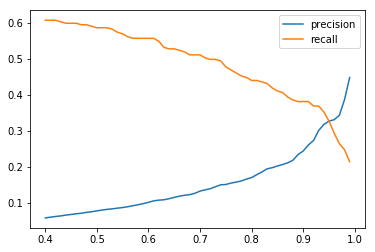

In [29]:
p=[]
r=[]
ts=[]

thresholds=np.arange(0.40, 1.00, 0.01)

for thres in thresholds:
    y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=thres else 0 )
    p1=precision_score(y_true=df.target, y_pred=y_pred, average=None)
    r1=recall_score(y_true=df.target, y_pred=y_pred, average=None)
    
    
    p.append(p1[1])
    r.append(r1[1])
    ts.append(thres)

plt.plot(ts,p,label='precision')    
plt.plot(ts,r,label='recall')    
plt.legend(loc='upper right')    